In [2]:
###IMPORT THE NEEDED LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pyxdf  # load file.xdf
import seaborn as sns
from scipy.signal import convolve2d # moving average
import os
import csv

# autoreload of preprocessing functions
%reload_ext autoreload
%autoreload 2
from Preprocessing_functions import *

In [4]:
pip install -U autoreject

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 5.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 13.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 12.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=f917d00accc4a0f5d33a1863f32df077a7e6ed53d124d5bf8c2c2b505172037a
  Stored in directory: /Users/Guest/Library/Caches/pip/wheels/a0/0b/ee/e6994fadb42c1354dcccb139b0bf2795271bddfe6253ccdf11
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [3]:
# get data path
MONTAGE = 'Data/montage_perfect.csv'
DICT_GROUP = 'Group_Realistic_Arm'

sub = 4
subb = 'S0' + str(sub)
subject = 'sub-S0' + str(sub)
DICT_EXPERIMENT = 'MIpost'

data_path_name = 'Data/' + DICT_GROUP + '/' + subb + '/' + subject + '_' + DICT_EXPERIMENT + '.xdf'
print('Data path: '+ data_path_name)

Data path: Data/Group_Realistic_Arm/S04/sub-S04_MIpost.xdf


In [4]:
#read montage
montage = pd.read_csv(MONTAGE, sep=',', header=None)
montage

0       1       2        3
0   ch_name       x       y        z
1       Fp1  -0.309   0.951      0.0
2       Fpz     0.0     1.0  -0.0001
3       Fp2   0.309   0.951      0.0
4        F7  -0.809   0.588      0.0
..      ...     ...     ...      ...
60      Tp7  -0.951  -0.309      0.0
61      Tp8   0.951  -0.309      0.0
62      Po7  -0.588  -0.809      0.0
63      Po8   0.588  -0.809      0.0
64       Oz     0.0    -1.0      0.0

[65 rows x 4 columns]

##### Initial step
Load data, load streams, bandpass filter the data, identify bad channels, interpolate bad channels

Stream 2: Calculated effective sampling rate 5158.9588 Hz is different from specified rate 500.0000 Hz.
Stream 3: Calculated effective sampling rate 15265.3711 Hz is different from specified rate 500.0000 Hz.


EEG data is being loaded
Stream found :1
Creating RawArray with float64 data, n_channels=66, n_times=1228009
    Range : 0 ... 1228008 =      0.000 ...   614.004 secs
Ready.

  
  Raw data information 
 
  <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, M1, T7, ...
 chs: 64 EEG, 1 misc, 1 BIO
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 2000.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.0s finished


Using matplotlib as 2D backend.


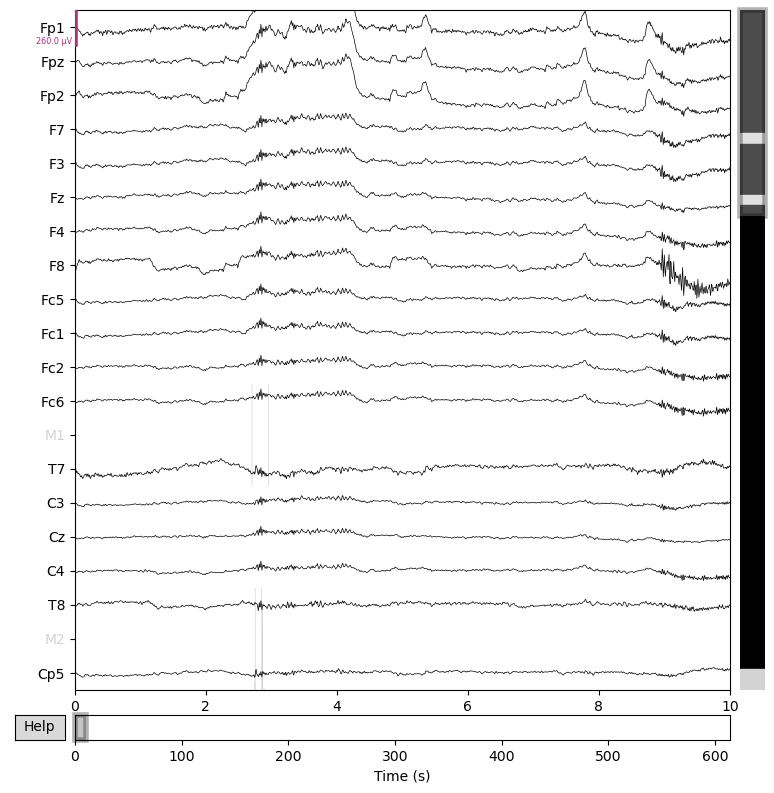

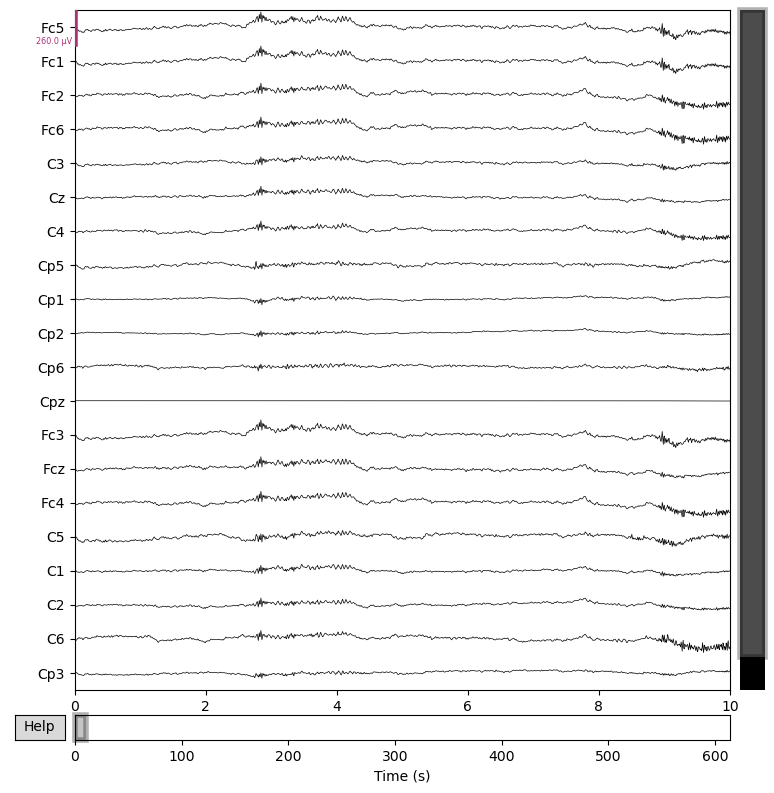

In [5]:
#get data from xdf file
streams, header = pyxdf.load_xdf(data_path_name)
# C_CHANNELS = ['C1', 'C2', 'C3', 'Cz', 'C4', 'C5', 'C6', 'Fc1', 'Fc2', 'Fc3', 'Fcz', 'Fc4', 'Fc5', 'Fc6', 'Cp1', 'Cp2', 'Cp3', 'Cp4', 'Cp5', 'Cp6', 'Cpz']
#get_raw_data also bandpass filters the data
raw_data = get_raw_data(streams, MONTAGE)

## raw data + bandpass filtered
### NOW ====> bad channels
bad_chs = []
#check bad channels in recap.csv
montage = get_montage(MONTAGE)
# int_data = interpolate_bad_channels(raw_data, montage, bad_channels = bad_chs)

In [6]:
#get the names of the channels
CHANNELS = raw_data.ch_names
#from channels drop "M1" "M2 "Trigger" "GSR"
CHANNELS = [x for x in CHANNELS if x not in ['M1', 'M2', 'Trigger', 'GSR', 'Cpz']]

print(CHANNELS)
print(len(CHANNELS))

['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Fc5', 'Fc1', 'Fc2', 'Fc6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'Cp5', 'Cp1', 'Cp2', 'Cp6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'Poz', 'O1', 'O2', 'Af7', 'Af3', 'Af4', 'Af8', 'F5', 'F1', 'F2', 'F6', 'Fc3', 'Fcz', 'Fc4', 'C5', 'C1', 'C2', 'C6', 'Cp3', 'Cp4', 'P5', 'P1', 'P2', 'P6', 'Po5', 'Po3', 'Po4', 'Po6', 'Ft7', 'Ft8', 'Tp7', 'Tp8', 'Po7', 'Po8', 'Oz']
61


In [14]:

# np.linalg.matrix_rank(raw_data.pick_channels(CHANNELS).get_data())

In [62]:
#compute correlation matrix across channels 
#DO THIS TO RUN ML IF PCA WHITENING DOES NOT WORK
CHANNELS2 = [x for x in CHANNELS if x not in ['M1', 'M2', 'Trigger', 'GSR', 'Cpz', 'Oz']]
# np.linalg.matrix_rank(raw_data.pick_channels(CHANNELS2).get_data())


In [8]:
print(len(CHANNELS))

61


In [132]:
streams[1]["info"]["desc"]

[defaultdict(list,
             {'channels': [defaultdict(list,
                           {'channel': [defaultdict(list,
                                         {'label': ['FP1'],
                                          'type': ['EEG'],
                                          'unit': ['uV']}),
                             defaultdict(list,
                                         {'label': ['FPZ'],
                                          'type': ['EEG'],
                                          'unit': ['uV']}),
                             defaultdict(list,
                                         {'label': ['FP2'],
                                          'type': ['EEG'],
                                          'unit': ['uV']}),
                             defaultdict(list,
                                         {'label': ['F7'],
                                          'type': ['EEG'],
                                          'unit': ['uV']}),
                      

In [10]:
raw_data.pick_channels(CHANNELS)
bads = []
# int_data = interpolate_bad_channels(raw_data, montage, bad_channels = bad_chs)


In [10]:
raw_data

<RawArray | 61 x 1228009 (614.0 s), ~571.6 MB, data loaded>

In [111]:
np.linalg.matrix_rank(raw_data.pick_channels(CHANNELS).get_data())

61

## ICA

In [11]:
ica = mne.preprocessing.ICA(n_components=20,random_state=0)
signal = raw_data.copy()
signal.set_montage(get_montage(MONTAGE),on_missing='warn')
ica.fit(signal.copy())

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 66.7s.


<ICA | raw data decomposition, method: fastica (fit in 44 iterations on 1228009 samples), 20 ICA components (61 PCA components available), channel types: eeg, no sources marked for exclusion>

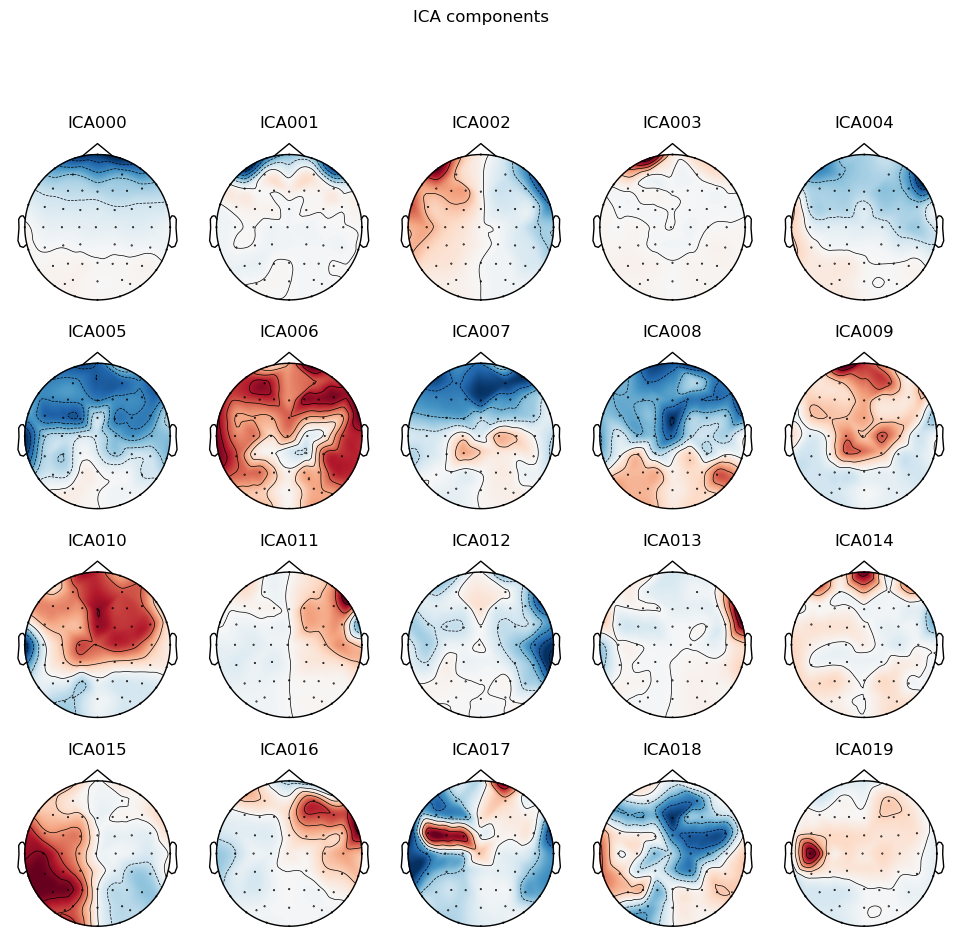

[<MNEFigure size 975x967 with 20 Axes>]

In [12]:
ica.plot_components()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    5.5s finished


Creating RawArray with float64 data, n_channels=20, n_times=1228009
    Range : 0 ... 1228008 =      0.000 ...   614.004 secs
Ready.


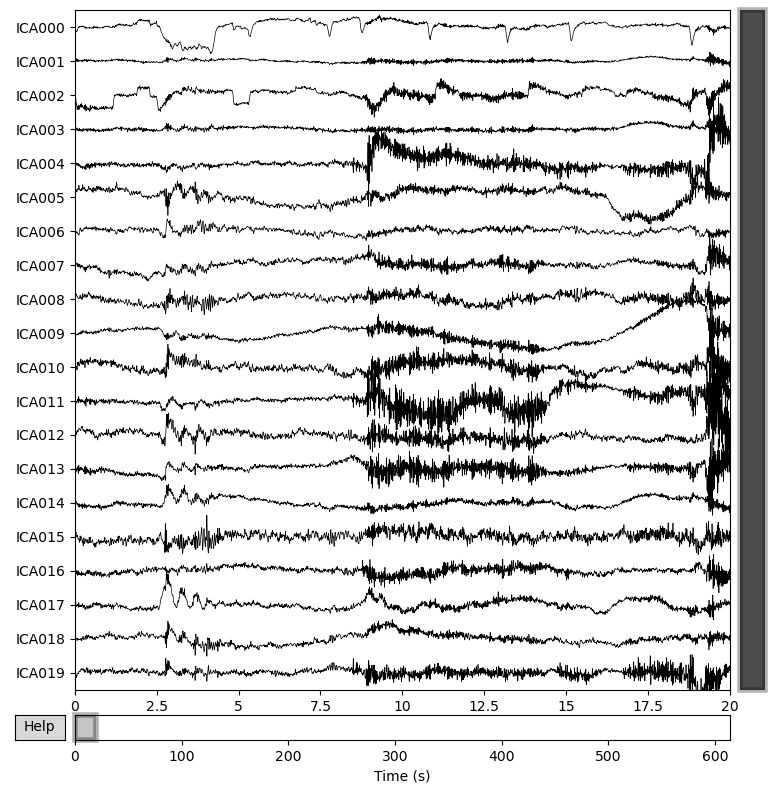

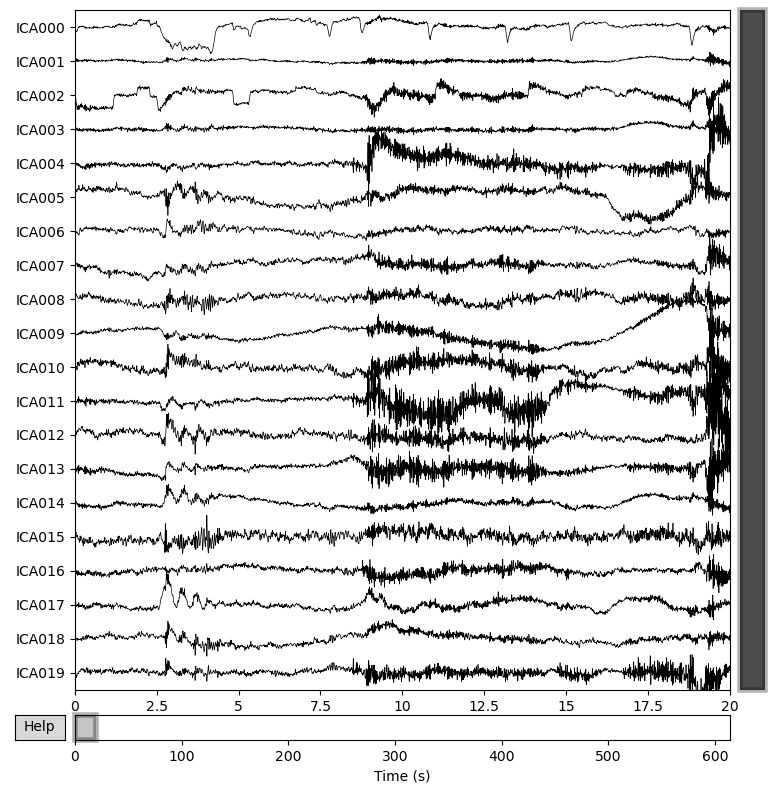

In [13]:
ica.plot_sources(signal.filter(0.1,40))

In [87]:
#save ica
ica.save('ica.fif')
#save ica in a variable
ica = mne.preprocessing.read_ica('ica.fif')

Writing ICA solution to c:\Users\Elena Grazia\EEG_TAMI\ica.fif...
Reading ica.fif ...


C:\Users\Elena Grazia\AppData\Local\Temp\ipykernel_15020\4211435025.py:2: RuntimeWarning: This filename (ica.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save('ica.fif')
C:\Users\Elena Grazia\AppData\Local\Temp\ipykernel_15020\4211435025.py:4: RuntimeWarning: This filename (ica.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = mne.preprocessing.read_ica('ica.fif')


Now restoring ICA solution ...
Ready.


In [10]:
filt_raw = raw_data.copy().filter(0.1,40)
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f'Fraction of {channel_type} variance explained by all components: '
        f'{ratio}'
    )

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    9.3s finished


Fraction of eeg variance explained by all components: 0.9869531100263939


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


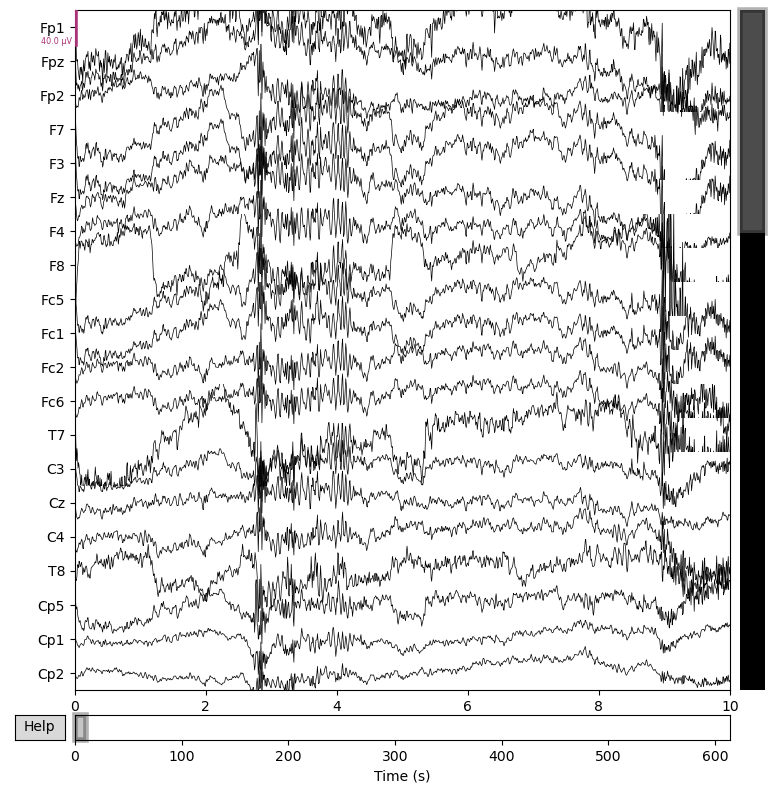

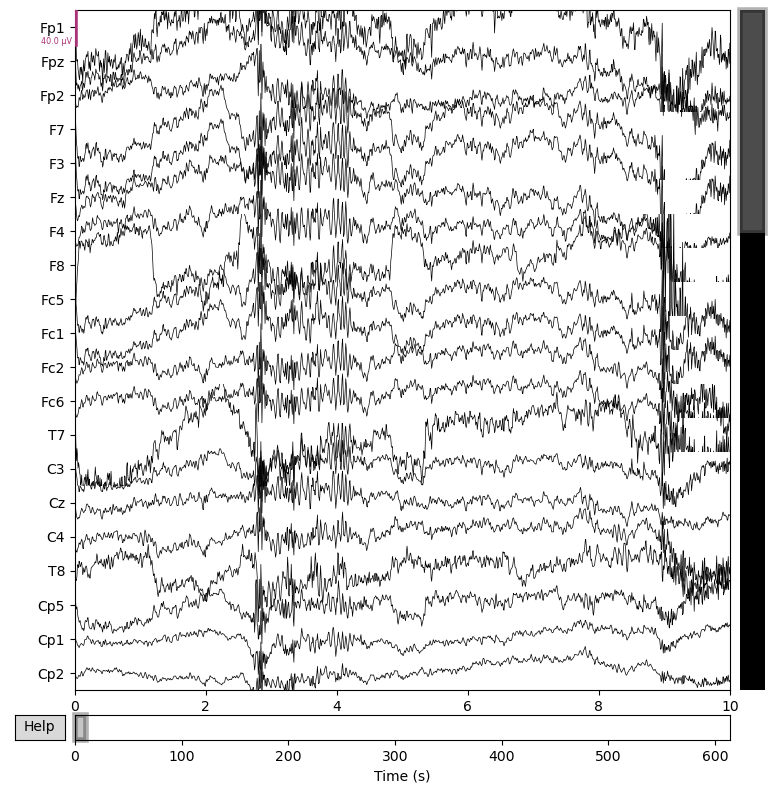

In [14]:
reconst_raw = raw_data.copy()
# artifact_picks = mne.pick_channels(raw_data.ch_names, regexp= 'C[1-61]')
# ica.apply() changes the Raw object in-place, so let's make a copy first:

reconst_raw = ica.apply(reconst_raw, exclude=[0,6])

# raw_data.plot()
reconst_raw.plot()


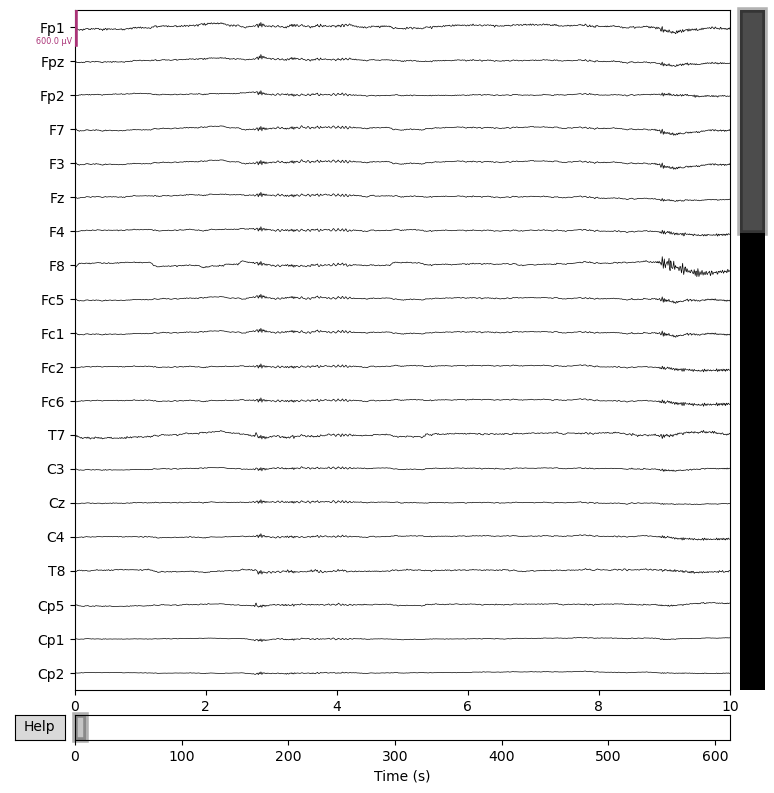

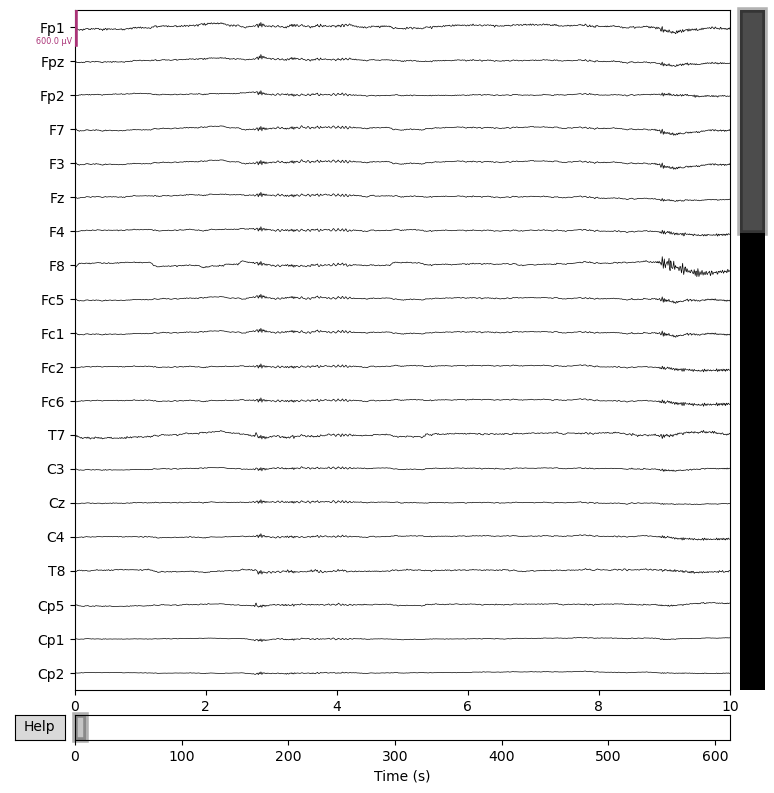

In [15]:
reconst_raw.plot(scalings = 0.0003)

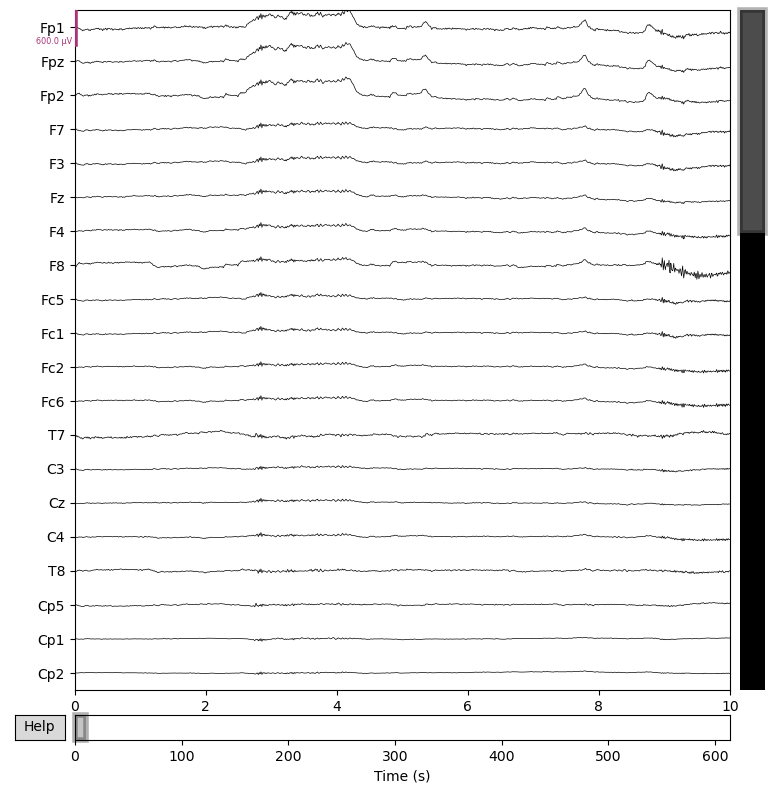

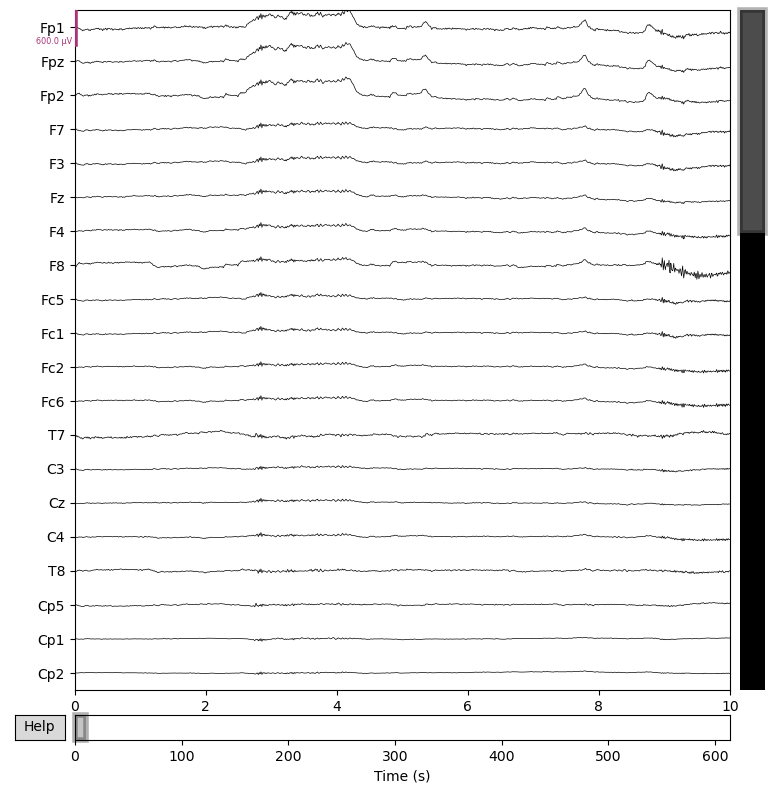

In [66]:
raw_data.plot(scalings = 0.0003)

In [68]:
reconst_raw.get_data().shape

(61, 1228009)

In [112]:
np.linalg.matrix_rank(reconst_raw.get_data())

61

In [28]:
raw_data.get_data().shape

(61, 1228009)

In [89]:
#save ica in a array
ica_array = ica.get_sources(signal.filter(0.1,40))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   14.9s finished


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


C:\Users\Elena Grazia\AppData\Local\Temp\ipykernel_40840\2492785956.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eeg_only.plot_psd(fmax=50)
c:\Users\Elena Grazia\anaconda3\envs\EEG_TAMI\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


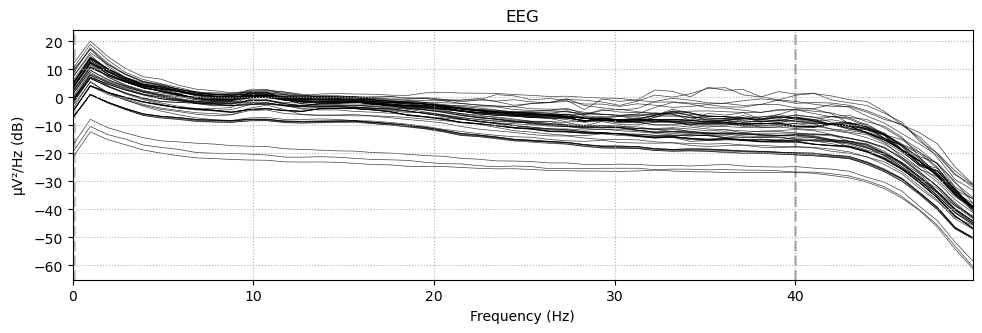

In [16]:
import mne.viz
##  compute the periodograms of the data
###  and plot the results

eeg_only = reconst_raw.copy().pick_types(meg=False, eeg=True)
#eeg_only.compute_psd(fmin =0.01, fmax=50).plot(dB = True)
eeg_only.plot_psd(fmax=50)

#### Epoching
Different procedure for MI trials and PO

In [17]:
Eeg = get_index_of_stream_type(streams, stream_type='EEG')
t_origin = streams[Eeg]['time_stamps'][0]

EEG data is being loaded
Stream found :1


In [18]:
if (DICT_EXPERIMENT== 'MIpre' or DICT_EXPERIMENT== 'MIpost'):
    
    Markers_cond = get_index_of_stream_type(streams, stream_type='MIMARKERCOND')
    target_nb = np.array(streams[Markers_cond]['time_series']).squeeze()  # array with target IDs
    Markers_time = get_index_of_stream_type(streams, stream_type='MIMARKERTIME')
    time_stamps = streams[Markers_time]['time_stamps']
    # t_origin = time_stamps[0]
    ts_1 = [time_stamps[0] - t_origin + 9* i for i in range(10)]
    # ts_2 = [time_stamps[90] - t_origin +2 + 9* i for i in range(30)]
    # time_stamps = np.concatenate((ts_1, ts_2))
    annots = mne.Annotations(onset=ts_1, duration=0., description=target_nb[:10])  
    raw_annotated = reconst_raw.copy().set_annotations(annots)
    events, event_ids = mne.events_from_annotations(raw_annotated)
    epochss = mne.Epochs(reconst_raw.pick_channels(CHANNELS), events, event_ids, tmin = -2, tmax = 7, baseline=(-2,0), reject_by_annotation=None, proj=False)
elif (DICT_EXPERIMENT== "PO"):
    print("PO")
    Markers= get_index_of_stream_type(streams, stream_type='POMARKER')
    target_nb = np.array(streams[Markers]['time_series']).squeeze()  # array with target IDs
    time_stamps = streams[Markers]['time_stamps'] - t_origin + 2
    annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)  
    raw_annotated = reconst_raw.copy().set_annotations(annots)
    events, event_ids = mne.events_from_annotations(raw_annotated)
    epochss = mne.Epochs(reconst_raw, events, event_ids, tmin = -2, tmax = 7, baseline=(-2,0), reject_by_annotation=None, proj=False)
else: 
   print("No experiment")

MI markers condition are being loaded
Stream found :0
MI markers time are being loaded
Stream found :2
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)


In [83]:
time_stamps[0] - t_origin

44.53754156344803

In [84]:
ts_1

[44.53754156344803,
 53.53754156344803,
 62.53754156344803,
 71.53754156344803,
 80.53754156344803,
 89.53754156344803,
 98.53754156344803,
 107.53754156344803,
 116.53754156344803,
 125.53754156344803]

In [103]:
epochss.get_data().shape

Using data from preloaded Raw for 10 events and 18001 original time points ...
0 bad epochs dropped


(10, 61, 18001)

In [87]:
epochss.get_data()

Using data from preloaded Raw for 10 events and 18001 original time points ...
0 bad epochs dropped


array([[[-8.54136820e-06, -8.49338692e-06, -8.44877651e-06, ...,
          4.26979054e-05,  4.27647814e-05,  4.27927561e-05],
        [-1.72588091e-05, -1.76125597e-05, -1.79574969e-05, ...,
          1.58133515e-05,  1.58127176e-05,  1.57899287e-05],
        [-6.34116494e-06, -6.65480705e-06, -6.94035786e-06, ...,
          1.25153864e-05,  1.24927559e-05,  1.24478839e-05],
        ...,
        [-4.36816750e-07, -6.14539140e-07, -7.91492433e-07, ...,
         -1.86561760e-06, -1.71529532e-06, -1.54735552e-06],
        [-5.21054517e-07, -3.05859252e-07, -9.62557515e-08, ...,
          2.98310910e-07,  2.40363167e-07,  1.83722166e-07],
        [-2.49363195e-07, -2.32350768e-07, -2.17872837e-07, ...,
         -1.18588135e-06, -1.18179849e-06, -1.17011188e-06]],

       [[ 1.60886632e-05,  1.60786224e-05,  1.60317638e-05, ...,
          4.08025667e-06,  3.95247654e-06,  3.84000176e-06],
        [ 4.70518180e-06,  4.66247375e-06,  4.60223889e-06, ...,
          1.72595062e-06,  1.61559581e

In [22]:
event_ids

{'Left': 1, 'Right': 2, 'Third': 3}

Using data from preloaded Raw for 10 events and 18001 original time points ...


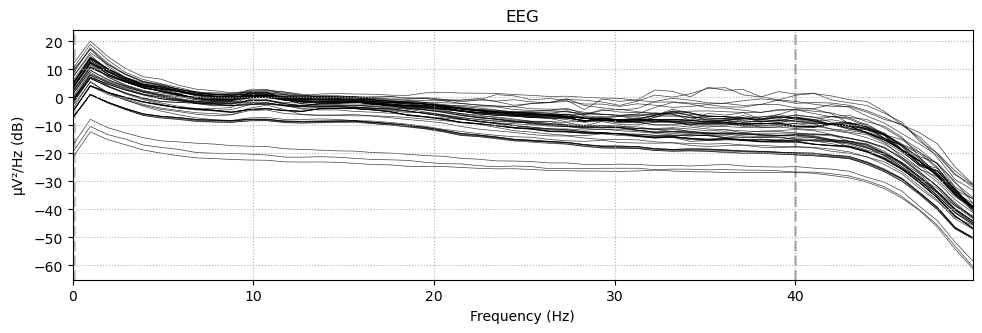

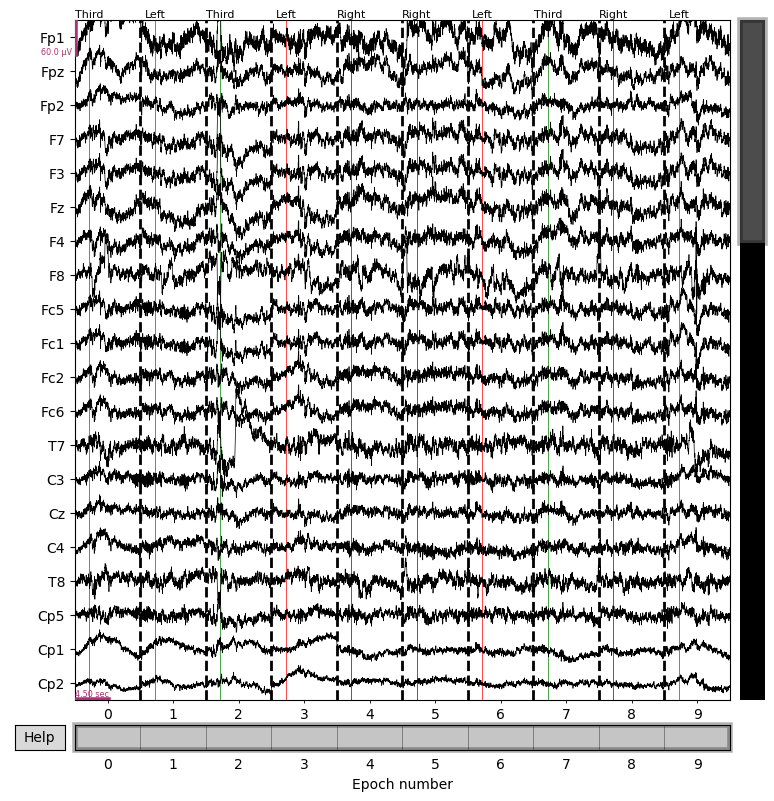

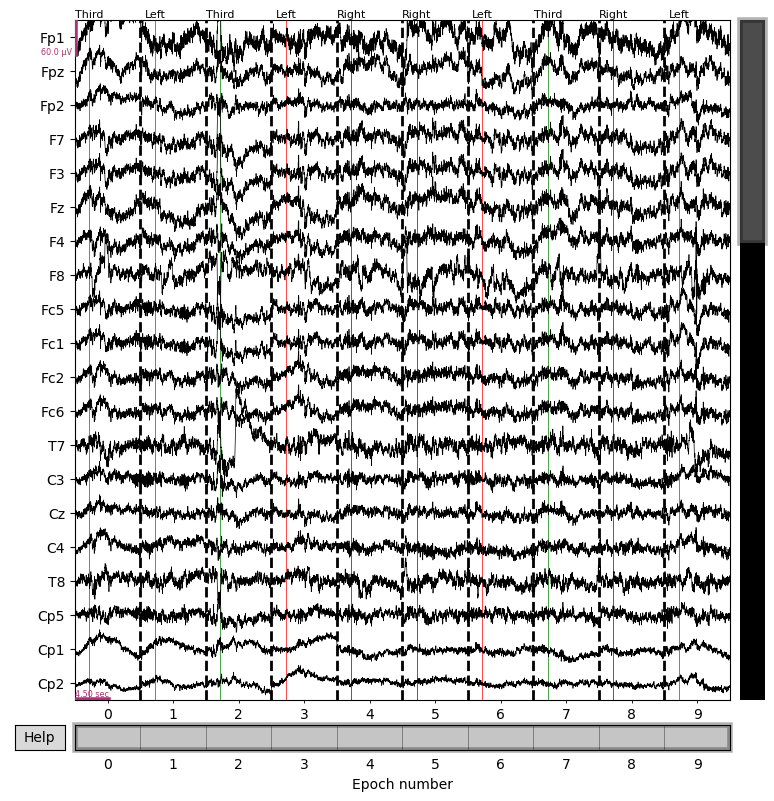

In [19]:
catch_trials_and_buttonpresses = mne.pick_events(events)
epochss.plot(events=catch_trials_and_buttonpresses, event_id=event_ids,
                    event_color=dict(Left='red', Right='blue', Third='green'), scalings = 0.00003)

In [97]:
epochss.events


array([[ 89075,      0,      3],
       [107075,      0,      1],
       [143075,      0,      1],
       [161075,      0,      2],
       [179075,      0,      2],
       [197075,      0,      1],
       [215075,      0,      3],
       [233075,      0,      2],
       [251075,      0,      1]])

Using data from preloaded Raw for 1 events and 18001 original time points ...
Computing rank from data with rank='full'
    EEG: rank 61 from info
Reducing data rank from 61 -> 61
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 18001
[done]
Computing rank from covariance with rank=None
    Using tolerance 4.5e-13 (2.2e-16 eps * 61 dim * 33  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 61 data channels with 0 projectors


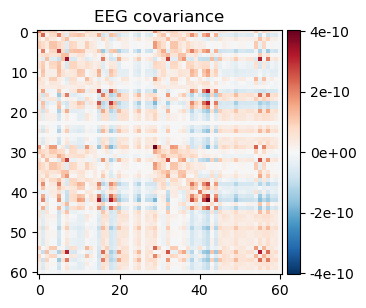

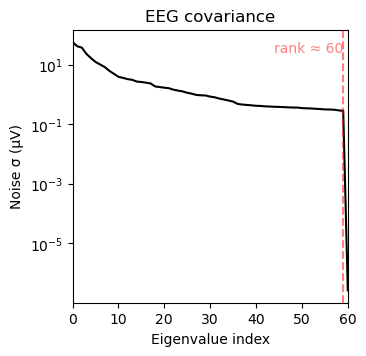

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [39]:
#plot the covariance matrix large dimensions
#plot in big screen
 
mne.compute_covariance(epochss[0], rank ='full').plot(info = epochss[0].info, show_svd = True)

Using data from preloaded Raw for 1 events and 18001 original time points ...


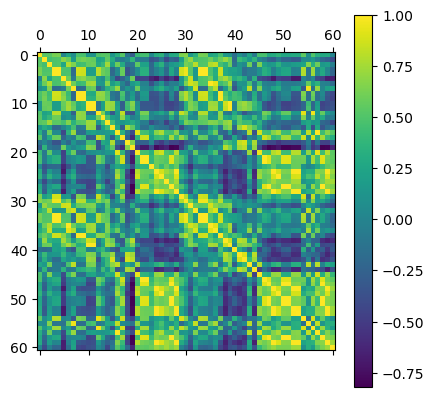

In [36]:
plt.matshow(np.corrcoef(epochss[0].get_data().reshape(61, -1)))
plt.colorbar()
plt.show()

In [37]:
# np.linalg.eig(epochss[0].get_data().reshape(61, -1))
np.linalg.qr(epochss[0].get_data().reshape(61, -1))

Using data from preloaded Raw for 1 events and 18001 original time points ...


(array([[-0.38340779, -0.09534713, -0.2904678 , ..., -0.05100593,
         -0.04603098,  0.04464422],
        [ 0.02275564, -0.24353284,  0.00331205, ...,  0.17693115,
          0.13262274, -0.31894361],
        [-0.19778414, -0.16145265, -0.0457799 , ..., -0.01158792,
         -0.07583213, -0.51077924],
        ...,
        [-0.00900087,  0.08468995, -0.17569814, ...,  0.04720676,
          0.20748452, -0.02184046],
        [-0.14314009, -0.0041029 ,  0.09691249, ..., -0.18688503,
         -0.11412954,  0.05418466],
        [-0.02190824,  0.01595205, -0.00677649, ...,  0.02117088,
         -0.03073669, -0.01894712]]),
 array([[ 4.37517128e-05,  4.44677189e-05,  4.50967801e-05, ...,
          1.54079754e-05,  1.54209738e-05,  1.54292323e-05],
        [ 0.00000000e+00,  2.54044181e-06,  4.87876470e-06, ...,
          3.79110608e-05,  3.87701037e-05,  3.94683109e-05],
        [ 0.00000000e+00,  0.00000000e+00, -1.62738408e-07, ...,
          3.13075991e-05,  3.18206244e-05,  3.22563949e-

In [38]:
print(np.sum(cov.data >= 0.0000001))

NameError: name 'cov' is not defined

In [89]:
print(np.sum(cov.data < - 0.0000001))

0


In [10]:
# TRY TO UNDERSTAND WHY IT DOES NOT WORK
# from autoreject import AutoReject
# ar = AutoReject()
# epochs_clean = ar.fit_transform(epochss)  

In [90]:
from autoreject import get_rejection_threshold
reject = get_rejection_threshold(epochss) 

Using data from preloaded Raw for 10 events and 18001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg


In [91]:
reject_criteria = dict(eeg=reject)

In [92]:
epochss = mne.Epochs(reconst_raw, events, event_ids, tmin = -2, tmax = 7, baseline=(-2,0), reject=reject, proj=False)
epochss.info

Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Fc5, Fc1, Fc2, Fc6, T7, C3, ...
 chs: 61 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 2000.0 Hz
>

In [20]:
## APPLY CAR FILTER
epochs_cared = filter_data(epochss.load_data(), filter_type='CAR')

Using data from preloaded Raw for 10 events and 18001 original time points ...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [34]:
epochs_mini = epochs_cared

In [21]:
print(epochs_mini.shape)

(7, 60, 18001)


In [131]:
print(epochs_mini.shape)
events_mini = epochs_cared.events[:20,:]
print(events_mini.shape)

(20, 60, 18001)
(20, 3)


In [120]:
events_mini = epochs_cared.events[:20, :]
print(events_mini.shape)

(20, 3)


In [15]:
#get only data of first 8 targets
epochs_mini = epochs_cared.get_data()[:20,:,:]

In [44]:
epochs_mini.shape

(8, 61, 18001)

## ERD

In [21]:
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

In [95]:
freqs = np.arange(0.1, 40.1, 1)  # frequencies from 0.1-40 Hz
vmin, vmax = -1.5, 1.5  # set min and max ERDS values in plot
baseline = (-2, 0)  # baseline interval (in s)
from matplotlib.colors import TwoSlopeNorm
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

In [113]:
import sys

In [120]:
print(sys.getsizeof(epochs_mini.get_data().astype(int)))

30745852


In [122]:
print(sys.getsizeof(epochs_mini.get_data()))

144


In [117]:
print(sys.getsizeof(epochs_mini.get_data().astype(float)

SyntaxError: unexpected EOF while parsing (3497582627.py, line 1)

In [111]:
epochss.get_data().astype(np.float32)

Using data from preloaded Raw for 10 events and 18001 original time points ...


MemoryError: Unable to allocate 83.8 MiB for an array with shape (10, 61, 18001) and data type float64

In [124]:
tfr = tfr_multitaper(epochs_mini, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr = tfr.astype(np.float32)                    
tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")

MemoryError: Unable to allocate 1.15 GiB for an array with shape (61, 7, 40, 9001) and data type float64

In [44]:
epochss.get_data().shape

(7, 60, 18001)

In [ ]:
tfr = tfr_multitaper(epochss, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")

In [ ]:
# plot the spectrogram using plot_tfr
fig, axs = plt.subplots(1, len(ch_names), figsize=(10, 4))
for idx, ch_name in enumerate(ch_names):
    plot_tfr(power, ch_idx=idx, baseline=None, mode='logratio',
             tmin=times[0], tmax=times[-1], fmin=1, fmax=20, axes=axs[idx])
    axs[idx].set(title=ch_name, xlabel='Time (s)', ylabel='Frequency (Hz)')

plt.show()

In [28]:
for event in event_ids:
    print(event)

Left
Right
Third


In [35]:
axes.shape

(60, 60)

In [33]:
fig, axes = plt.subplots(len(CHANNELS2), len(CHANNELS2), figsize=(12, 4))

In [39]:
#I have 60 channels and I need to have an axis for each channel
fig, axes = plt.subplots


In [61]:
tfr["Third"].ch_names

['Fp1',
 'Fpz',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'Fc5',
 'Fc1',
 'Fc2',
 'Fc6',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'Cp5',
 'Cp1',
 'Cp2',
 'Cp6',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'Poz',
 'O1',
 'O2',
 'Af7',
 'Af3',
 'Af4',
 'Af8',
 'F5',
 'F1',
 'F2',
 'F6',
 'Fc3',
 'Fcz',
 'Fc4',
 'C5',
 'C1',
 'C2',
 'C6',
 'Cp3',
 'Cp4',
 'P5',
 'P1',
 'P2',
 'P6',
 'Po5',
 'Po3',
 'Po4',
 'Po6',
 'Ft7',
 'Ft8',
 'Tp7',
 'Tp8',
 'Po7',
 'Po8']

In [60]:
# for event in event_ids:
    # select desired epochs for visualization (choose condition (ex:Third))
tfr_ev = tfr["Third"]
fig, axes = plt.subplots(60, 4, figsize=(12, 4),
                            gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    
for ch, ax in enumerate(axes):  # for each channel
      
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)
        # Non-parametric cluster-level paired t-test across all trials of a given coindition

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,

                              colorbar=False, show=False, mask=None)
                            #   mask_style="mask")

        ax.set_title(epochss.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
fig.suptitle(f"ERDS ({event})")
plt.show()

Using a threshold of 6.313752
stat_fun(H1): min=-1974959.781054 max=24982.740678
Running initial clustering …
Found 571 clusters


100%|██████████| Permuting (exact test) : 3/3 [00:01<00:00,    2.61it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -6.313752


stat_fun(H1): min=-1974959.781054 max=24982.740678
Running initial clustering …
Found 689 clusters


100%|██████████| Permuting (exact test) : 3/3 [00:01<00:00,    2.25it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations


No baseline correction applied


RuntimeError: There must be an axes for each picked channel.

In [68]:
row = 20
col  = 3

In [34]:
for i in range(3):
    print(i)

0
1
2


In [40]:
axes.shape

(20, 3)

In [69]:
tfr_ev = tfr["Third"]
fig, axes = plt.subplots(row,col, figsize=(500, 200), sharex=True, sharey=True)
                        #     gridspec_kw={"width_ratios": [10, 10, 10, 1]})
   
for i in range(row):

        for j in range(col):   # for each channel
                ch = i*3 + j
                ax = axes[i,j]

      
        # positive clusters print(ax)
        # _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        # _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)
        # Non-parametric cluster-level paired t-test across all trials of a given coindition

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        # c = np.stack(c1 + c2, axis=2)  # combined clusters
        # p = np.concatenate((p1, p2))  # combined p-values
        # mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
                if(j==2):
                        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax, colorbar=True, show=False, mask=None)
                else:
                        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax, colorbar=False, show=False, mask=None)

                ax.set_title(epochss.ch_names[ch], fontsize=10)              # colorbar=False, show=False, mask=None)
                            #   mask_style="mask")

       
        # ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        # if ch != 0:
        #     ax.set_ylabel("")
        #     ax.set_yticklabels("")
# fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
# fig.suptitle(f"ERDS ({event})")

plt.show()

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

MemoryError: In RendererAgg: Out of memory

<Figure size 50000x20000 with 83 Axes>

MemoryError: In RendererAgg: Out of memory

<Figure size 50000x20000 with 80 Axes>

In [48]:
len(axes)

20

In [43]:
#get dataframe
df = tfr.to_data_frame(time_format=None)
df.head()

MemoryError: Unable to allocate 1.13 GiB for an array with shape (7, 40, 9001, 60) and data type float64

In [72]:
df2 = df.groupby(["time", "freq"]).median()
df2.head()

C:\Users\Elena Grazia\AppData\Local\Temp\ipykernel_27532\1313346075.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(["time", "freq"]).median()


epoch       Fp1       Fpz       Fp2        F7        F3        Fz  \
time freq                                                                      
-2.0 0.1     5.0 -0.631009 -0.580545 -0.071694 -0.892973 -0.896887 -0.574553   
     1.1     5.0 -0.620298 -0.537417 -0.109958 -0.863580 -0.873612 -0.541671   
     2.1     5.0 -0.448692 -0.564882 -0.190424 -0.704476 -0.705087 -0.569422   
     3.1     5.0 -0.492763 -0.350567 -0.627992 -0.355478 -0.389603 -0.380376   
     4.1     5.0 -0.524166 -0.547936 -0.590528 -0.691017 -0.692889 -0.442157   

                 F4        F8       Fc5  ...       Po5       Po3       Po4  \
time freq                                ...                                 
-2.0 0.1  -0.765001 -0.782912 -0.699498  ...  0.040001  0.020253 -0.713501   
     1.1  -0.687354 -0.631952 -0.682940  ... -0.088072 -0.083803 -0.699660   
     2.1  -0.710121 -0.656388 -0.680941  ... -0.096538 -0.114730 -0.635151   
     3.1  -0.531155 -0.617005 -0.315343  ... -0.139660 -0.099222 -0.481829   
     4.1  -0.488226 -0.741967 -0.659115  ... -0.389664 -0.353064 -0.334274   

                Po6       Ft7       Ft8       Tp7       Tp8       Po7  \
time freq                                                               
-2.0 0.1  -0.772273 -0.845369 -0.769175 -0.345142 -0.773177 -0.011163   
     1.1  -0.763780 -0.725259 -0.624292 -0.394027 -0.534274 -0.076412   
     2.1  -0.702815 -0.698024 -0.637039 -0.391394 -0.417766 -0.188219   
     3.1  -0.536493 -0.466923 -0.498749 -0.411207 -0.481940 -0.031983   
     4.1  -0.395550 -0.562823 -0.706862 -0.553097 -0.225069 -0.435787   

                Po8  
time freq            
-2.0 0.1  -0.743943  
     1.1  -0.775501  
     2.1  -0.552252  
     3.1  -0.411295  
     4.1  -0.433605  

[5 rows x 61 columns]

In [42]:
#select the channel you want to plot
df3 = df2.loc[df2["channel"] == "Fp1"]


NameError: name 'df2' is not defined

In [69]:
tfr_ev.average()

<AverageTFR | time : [-2.000000, 7.000000], freq : [0.100000, 39.100000], nave : 2, channels : 60, ~164.9 MB>

In [151]:
epochs_mini.shape

(8, 62, 18001)

In [30]:
#get shape
df.shape

(18002000, 66)

In [32]:
#save dataframe
df.to_csv("df_TFR.csv")

In [110]:
#read df_TFR
df = pd.read_csv("df_TFR.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'df_TFR.csv'

In [37]:
#Compute the median across epochs (on a test data )
range = np.arange(3)
df_third_subset = df.loc[(df["epoch"].isin(range)) & (df["condition"]=="Third")]

# df_subsetroupby(["time", "freq"]).mean()
#[00:12<00:00,    7.90it/s]

In [38]:
df_third_subset.groupby(["time", "freq"]).median()

/var/folders/zz/zyxvpxvq6csfxvn_n00000s4000069/T/ipykernel_45747/2290916117.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_third_subset.groupby(["time", "freq"]).median()


epoch       Fp1       Fpz       Fp2        F7        F3        Fz  \
time freq                                                                      
-2.0 0.1     1.0 -0.326826 -0.706684 -0.584657 -0.483392 -0.480262  0.266090   
     1.1     1.0 -0.574322 -0.839110 -0.639338 -0.511037 -0.479405 -0.210661   
     2.1     1.0 -0.640229 -0.801344 -0.732656 -0.441530 -0.407577 -0.260012   
     3.1     1.0 -0.677705 -0.752633 -0.678044 -0.415013 -0.366928 -0.484502   
     4.1     1.0 -0.679952 -0.684475 -0.737440 -0.358095 -0.295176 -0.489527   
...          ...       ...       ...       ...       ...       ...       ...   
 7.0 35.1    1.0  0.060367  0.243247 -0.639894  0.062760 -0.256688 -0.594975   
     36.1    1.0 -0.188767  0.025454 -0.768886 -0.146998 -0.285422 -0.638328   
     37.1    1.0 -0.406682  0.006082 -0.586024 -0.002074 -0.199757 -0.800861   
     38.1    1.0 -0.593977 -0.430170 -0.326898 -0.315462 -0.534173 -0.817862   
     39.1    1.0 -0.919584 -0.883776 -0.276603 -0.449008 -0.412380 -0.473354   

                 F4        F8       Fc5  ...       Po3       Po4       Po6  \
time freq                                ...                                 
-2.0 0.1  -0.318507 -0.726010 -0.380022  ... -0.573676 -0.733786 -0.725327   
     1.1  -0.181802 -0.298988 -0.352983  ... -0.490602 -0.727658 -0.734268   
     2.1  -0.281006 -0.360493 -0.237519  ... -0.683079 -0.690835 -0.705152   
     3.1  -0.382104 -0.245499 -0.287532  ... -0.551968 -0.296311 -0.256150   
     4.1  -0.471702 -0.525375 -0.488443  ... -0.260410 -0.095529 -0.080840   
...             ...       ...       ...  ...       ...       ...       ...   
 7.0 35.1 -0.397192 -0.746035 -0.266310  ...  0.017828 -0.660415 -0.648317   
     36.1 -0.728826 -0.612632 -0.408926  ...  0.102244 -0.535328 -0.502349   
     37.1 -0.919714 -0.784902 -0.511349  ... -0.117371 -0.455303 -0.428089   
     38.1 -0.926792 -0.619644 -0.585936  ...  0.187996 -0.354844 -0.325771   
     39.1 -0.745287 -0.693901 -0.340368  ...  0.027326  0.178315  0.107042   

                Ft7       Ft8       Tp7       Tp8       Po7       Po8  \
time freq                                                               
-2.0 0.1  -0.693411 -0.689979 -0.666165 -0.397110 -0.606458 -0.758619   
     1.1  -0.685802 -0.300116 -0.594833 -0.257157 -0.520983 -0.721625   
     2.1  -0.540484 -0.315252 -0.676627 -0.096388 -0.698694 -0.689622   
     3.1  -0.351162 -0.160172 -0.387202 -0.001943 -0.506970 -0.394416   
     4.1  -0.028451 -0.412949  0.042744 -0.247388 -0.200356 -0.169508   
...             ...       ...       ...       ...       ...       ...   
 7.0 35.1 -0.604001 -0.651179  0.297602 -0.597073 -0.177401 -0.675540   
     36.1 -0.542998 -0.474087 -0.082546 -0.674810 -0.122416 -0.649742   
     37.1 -0.427733 -0.648407  0.068841 -0.417077 -0.130658 -0.571051   
     38.1 -0.551651 -0.624297 -0.365267 -0.601955 -0.121684 -0.585820   
     39.1 -0.604320 -0.697331 -0.217222 -0.600065 -0.104789 -0.386793   

                 Oz  
time freq            
-2.0 0.1  -0.743083  
     1.1  -0.649296  
     2.1  -0.693390  
     3.1  -0.262097  
     4.1  -0.011035  
...             ...  
 7.0 35.1 -0.347178  
     36.1 -0.252127  
     37.1 -0.489281  
     38.1 -0.575953  
     39.1 -0.455235  

[360040 rows x 63 columns]

## ML 

In [22]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
# from mne.datasets import eegbci
from mne.decoding import CSP

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
#import UnsupervisedSpatialFilter
from mne.decoding import UnsupervisedSpatialFilter
#import PCA
from sklearn.decomposition import PCA



In [24]:
#import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
#import cv split


# PCA

In [25]:
X = epochss.get_data()
pca = UnsupervisedSpatialFilter(PCA(61), average=False)
pca_data = pca.fit_transform(X)

In [26]:
np.linalg.matrix_rank(pca_data)

array([59, 59, 59, 59, 59, 59, 59, 59, 59, 59], dtype=int64)

In [27]:
epochs2 = epochss.copy() 

x = pca_data
y = epochs2.events[:, -1]
# binarize the labels : Real arms vs Unreal arms
# y  = np.floor(y/3)

# train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)


## Cross validation with CSP and SVM 

# define the pipeline
pipe = Pipeline([
    ('csp', CSP()),
    ('svc', SVC(probability=True))
])


In [143]:
print(len(x))
print(len(y))

10
10


In [53]:
epochs_cared.events[:, -1]

array([3, 1, 2, 2, 1, 3, 2])

In [28]:
y

array([3, 1, 3, 1, 2, 2, 1, 3, 2, 1])

In [ ]:
y = epochss.events[:20, -1]
# binarize the labels : Real arms vs Unreal arms
y  = np.floor(y/3)

# train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)


## Cross validation with CSP and SVM 

# define the pipeline
pipe = Pipeline([
    ('csp', CSP()),
    ('svc', SVC(probability=True))
])


In [53]:
y

array([1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0.])

In [29]:
p_grid = {
    'csp__n_components': [3, 4, 6],
    'svc__C': [1e-2, 1e-1, 1, 10, 1e2], #regularization parameter
    'svc__kernel': ['linear', 'rbf'], #kernel type
    'svc__gamma': np.logspace(1e-6, 1, 10) #kernel coefficient
}

In [30]:
cv_inner = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)          #1
cv_outer = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [31]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, make_scorer

In [32]:
#compute rank of matrix
np.linalg.matrix_rank(pca_data)

array([59, 59, 59, 59, 59, 59, 59, 59, 59, 59], dtype=int64)

In [1]:
y

NameError: name 'y' is not defined

In [33]:

history = []
best_models = []
best_params = []

pointer = 1
for train_index, test_index in cv_outer.split(x, y):                          #3
    print('\nNestedCV: {} of outer fold {}'.format(pointer, cv_outer.get_n_splits()))
    x_train, x_test = x[train_index, :, :], x[test_index, :, :]
    y_train, y_test = y[train_index], y[test_index]

    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    # x_train = np.nan_to_num(x_train, nan=-99)
    # x_test = np.nan_to_num(x_test, nan=-99)

    model = RandomizedSearchCV(pipe, param_distributions=p_grid,
                                  scoring='balanced_accuracy', cv=cv_inner, n_jobs=-1)     #4
    model.fit(x_train, y_train)
    
    pred_test = model.predict(x_test)
    pred_training = model.predict(x_train)
    
    ba_train = balanced_accuracy_score(y_train, pred_training)                   #5
    ba_test = balanced_accuracy_score(y_test, pred_test)
    
    print("""
    # Best set of parameters: {}
    # Best BA             : {:.2f}

    # Training
        # BA: {:.3f}
    # Test
        # BA: {:.3f}
    # """.format(
        model.best_params_,
        model.best_score_,
        ba_train,
        ba_test,
        )
    )
    history.append(ba_test)
    best_models.append(model.best_estimator_)
    best_params.append(model.best_params_)
    pointer += 1

print('Overall test performance: {:.2f}'.format(np.mean(history)))


NestedCV: 1 of outer fold 2
(5, 61, 18001)
(5, 61, 18001)
(5,)
(5,)


c:\Users\Elena Grazia\anaconda3\envs\EEG_TAMI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 61 dim * 9.4e+09  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 61 dim * 9.6e+09  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-05 (2.2e-16 eps * 61 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 

c:\Users\Elena Grazia\anaconda3\envs\EEG_TAMI\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 61 dim * 9.1e+09  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.4e-05 (2.2e-16 eps * 61 dim * 7e+09  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 61 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 59


In [34]:
best_p = best_params[np.argmax(history)]

In [35]:
best_p

{'svc__kernel': 'linear',
 'svc__gamma': 1.66810352460318,
 'svc__C': 10,
 'csp__n_components': 4}

In [36]:
display(np.max(history))
display(best_models[np.argmax(history)])

0.5

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('svc',
                 SVC(C=10, gamma=1.66810352460318, kernel='linear',
                     probability=True))])

In [37]:
best_models[np.argmax(history)]

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('svc',
                 SVC(C=10, gamma=1.66810352460318, kernel='linear',
                     probability=True))])

In [38]:
best_models[np.argmax(history)].fit(x,y)

Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 61 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 61 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 61 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 61 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 

Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 4,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('svc',
                 SVC(C=10, gamma=1.66810352460318, kernel='linear',
                     probability=True))])

In [81]:
tommy = best_models[np.argmax(history)]
tommy.fit(x,y)

Computing rank from data with rank=None
    Using tolerance 0.00036 (2.2e-16 eps * 60 dim * 2.7e+10  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 60 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.


Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})),
                ('svc', SVC(C=10, gamma=5.994845570664637, probability=True))])

In [39]:
display(best_models)

[Pipeline(steps=[('csp',
                  CSP({'component_order': 'mutual_info',
  'cov_est': 'concat',
  'cov_method_params': None,
  'log': None,
  'n_components': 6,
  'norm_trace': False,
  'rank': None,
  'reg': None,
  'transform_into': 'average_power'})),
                 ('svc',
                  SVC(C=10, gamma=10.0, kernel='linear', probability=True))]),
 Pipeline(steps=[('csp',
                  CSP({'component_order': 'mutual_info',
  'cov_est': 'concat',
  'cov_method_params': None,
  'log': None,
  'n_components': 4,
  'norm_trace': False,
  'rank': None,
  'reg': None,
  'transform_into': 'average_power'})),
                 ('svc',
                  SVC(C=10, gamma=1.66810352460318, kernel='linear',
                      probability=True))])]

In [73]:
#split train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [78]:
# initialize a new pipeline with the best parameters
pipe_best = Pipeline([
    ('csp', CSP(n_components=best_p['csp__n_components'])),
    ('svc', SVC(C=best_p['svc__C'], kernel=best_p['svc__kernel'], gamma=best_p['svc__gamma']))
])

# fit the new pipeline to the test data
pipe_best.fit(X_train, y_train)

# make predictions on the test data
y_pred = pipe_best.predict(X_test)

# calculate the f1-score on the test data
f1 = f1_score(y_test, y_pred)

#balanced accuracy
ba = balanced_accuracy_score(y_test, y_pred)

# calculate the confusion matrix on the test data
conf_mat = confusion_matrix(y_test, y_pred)

Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 60 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00023 (2.2e-16 eps * 60 dim * 1.8e+10  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.


In [44]:
std_hist_svc = np.std(history)
std_hist_svc

0.08333333333333334

## RANDOM FOREST


In [ ]:
#import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#define a pipeline calling Random Forest and csp
pipe = Pipeline([
    ('csp', CSP()),
    ('rf', RandomForestClassifier())
])

In [83]:
param_grid = {
    'csp__n_components': [3, 4, 6],
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [2, 4, 8, 16, 32, None]
}

In [ ]:
history = []
best_models = []
best_params = []

pointer = 1
for train_index, test_index in cv_outer.split(x, y):                          #3
    print('\nNestedCV: {} of outer fold {}'.format(pointer, cv_outer.get_n_splits()))
    x_train, x_test = x[train_index, :, :], x[test_index, :, :]
    y_train, y_test = y[train_index], y[test_index]

    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    # x_train = np.nan_to_num(x_train, nan=-99)
    # x_test = np.nan_to_num(x_test, nan=-99)

    model = RandomizedSearchCV(pipe, param_distributions=p_grid,
                                  scoring='balanced_accuracy', cv=cv_inner, n_jobs=-1)     #4
    model.fit(x_train, y_train)
    
    pred_test = model.predict(x_test)
    pred_training = model.predict(x_train)
    
    ba_train = balanced_accuracy_score(y_train, pred_training)                   #5
    ba_test = balanced_accuracy_score(y_test, pred_test)
    
    print("""
    # Best set of parameters: {}
    # Best BA             : {:.2f}

    # Training
        # BA: {:.3f}
    # Test
        # BA: {:.3f}
    # """.format(
        model.best_params_,
        model.best_score_,
        ba_train,
        ba_test,
        )
    )
    history.append(ba_test)
    best_models.append(model.best_estimator_)
    best_params.append(model.best_params_)
    pointer += 1

print('Overall test performance: {:.2f}'.format(np.mean(history)))

In [ ]:
best_p = best_params[np.argmax(history)]

In [ ]:
display(np.max(history))
display(best_models[np.argmax(history)])

In [ ]:
best_m = best_models[np.argmax(history)]
best_m.fit(x,y)

In [ ]:
pred = best_m.predict(x)
balanced_accuracy_score(y, pred)